# Simple loading & training using zmq_ops

using minst_server in tensorcom for sending data


`
python3 ./serve-mnist zpub://127.0.0.1:7880
`

In [1]:
import sys
import math
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorcom
from nvzmq_ops import ZmqOp
import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
_BATCH_SIZE = 32
_NUM_CLASS=10
IMAGE_SIZE = 28
_NUM_IMAGES = {'train': 60000,
              'val': 10000}

TYPES = [tf.dtypes.as_dtype(np.dtype('float16')), tf.dtypes.as_dtype(np.dtype('int32'))]


In [3]:
def load_items(types, is_train):
    zmq_op = ZmqOp(address="zsub://127.0.0.1:7880", zmq_hwm=200, zmq_buff=10240)
    x, y = zmq_op.pull(types)
    while True:
        if is_train:
            pass
        x = tf.reshape(x, (_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE))
        y = tf.one_hot(y, _NUM_CLASS)
        yield x, y

In [4]:
sess =  tf.Session()

<class 'numpy.ndarray'> float16 (32, 28, 28)
float32 (32, 10)


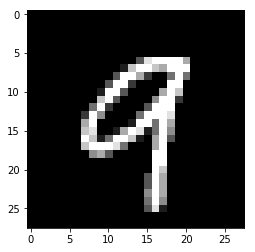

In [5]:
data, target = sess.run(next(load_items(TYPES, True)))
print(type(data), data.dtype, data.shape)
print(target.dtype, target.shape)
plt.imshow(data[0].astype("float32"), cmap='gray')

In [6]:
num_train_batches = _NUM_IMAGES['train'] // _BATCH_SIZE
num_val_batches = _NUM_IMAGES['val'] // _BATCH_SIZE
train_dataset = tf.data.Dataset.from_tensors(0).repeat().map(lambda _: next(load_items(TYPES, True)))
val_dataset = tf.data.Dataset.from_tensors(0).repeat().map(lambda _: next(load_items(TYPES, False)))

In [7]:
# train_iter = train_dataset.make_initializable_iterator()
# val_iter = val_dataset.make_initializable_iterator()
# images, labels = train_iter.get_next()

train_iter = train_dataset.make_one_shot_iterator()
val_iter = val_dataset.make_one_shot_iterator()

In [8]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_iter, epochs=5, steps_per_epoch=num_train_batches)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2139 - acc: 0.9352
Epoch 2/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1096 - acc: 0.9664
Epoch 3/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0880 - acc: 0.9723
Epoch 4/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0753 - acc: 0.9762
Epoch 5/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0641 - acc: 0.9799


In [9]:
model.evaluate(val_dataset, steps=num_val_batches)

312/312 [==============================] - 1s 4ms/step - loss: 0.0346 - acc: 0.9901


[0.03462819069460611, 0.9900841]